In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from networkx import DiGraph

from matplotlib.patches import FancyArrowPatch, Circle, Ellipse

In [2]:
from GraphDrawer import Graph

### Generating Data


In [3]:
from ProcessGenerator import FeatureGenerator, SimpleProcessMaker

In [4]:
stages = np.array(['A', 'B', 'C', 'D', 'E', 'F'])
probas=np.array([0.1, 0.8, 0.7, 0.5, 0.5, 0.03])
maker = SimpleProcessMaker(stages=stages, probas=probas)

In [5]:
gen_df = pd.DataFrame()
for idx in range(100):
    d = maker.make_process_sample(idx)
    gen_df = gen_df.append(d)
    
gen_df

,id,stages,dt
0,0,A,2020-01-01
1,0,E,2020-01-08
2,0,D,2020-01-10
3,0,F,2020-01-15
0,1,D,2020-01-01
...,...,...,...
0,98,A,2020-01-01
1,98,E,2020-01-06
2,98,F,2020-01-08
0,99,A,2020-01-01


In [6]:
gen = FeatureGenerator()

In [7]:
num_users = 5
gen_df['user'] = ['user_' + gen.label_features(label_type='string', nb_unique_labels=num_users)[0][-1] for _ in range(len(gen_df))]
gen_df.head()

,id,stages,dt,user
0,0,A,2020-01-01,user_1
1,0,E,2020-01-08,user_2
2,0,D,2020-01-10,user_0
3,0,F,2020-01-15,user_1
0,1,D,2020-01-01,user_1


In [8]:
gen_df["user_id"] = gen_df['user']
gen_df['stage_id'] = gen_df['stages']

act_id = dict()
id_act = dict()
usr_id = dict()
id_usr = dict()

for i, act in enumerate(np.unique(gen_df.stages)):
    act_id[act] = i
    id_act[i] = act

for i, usr in enumerate(np.unique(gen_df.user)):
    usr_id[usr] = i
    id_usr[i] = usr

    
user_id = [usr_id[x] for x in gen_df['user'].values]
stage_id = [act_id[x] for x in gen_df['stages'].values]

gen_df.user_id = user_id
gen_df.stage_id = stage_id

### Creating graphs

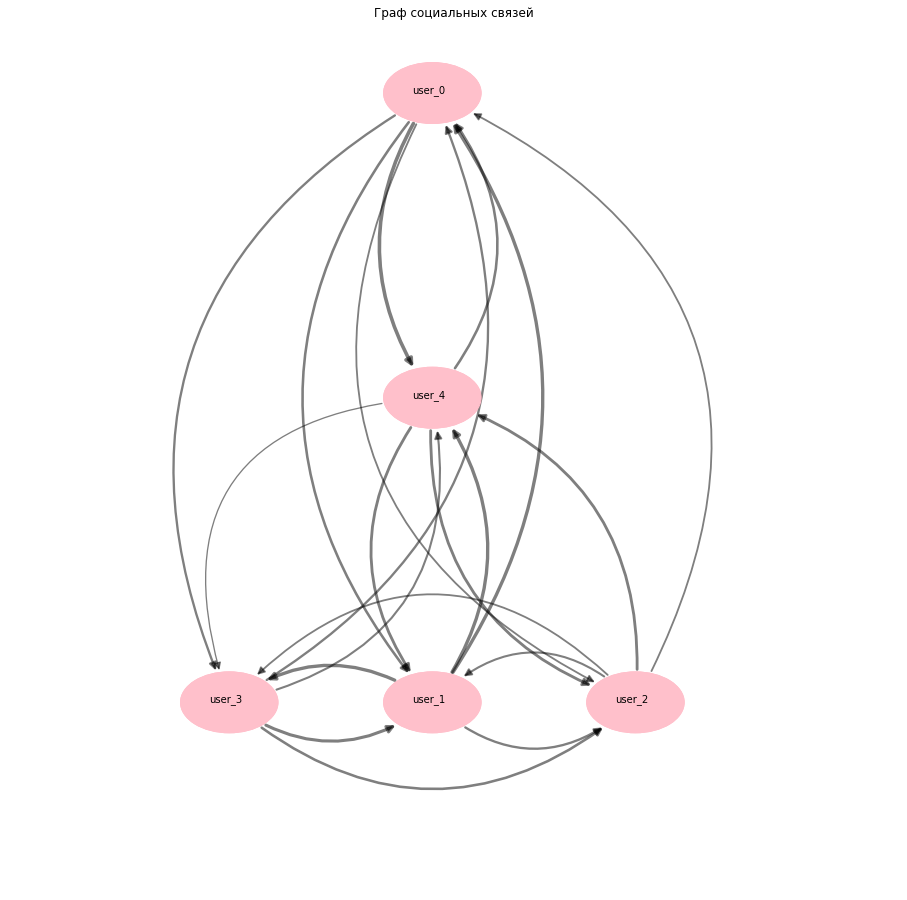

In [9]:
graph = Graph(gen_df, 'id', 'stages', 'user_id')
graph.create_users_graph()
graph.draw_users(alpha=0.8, labels=id_usr)

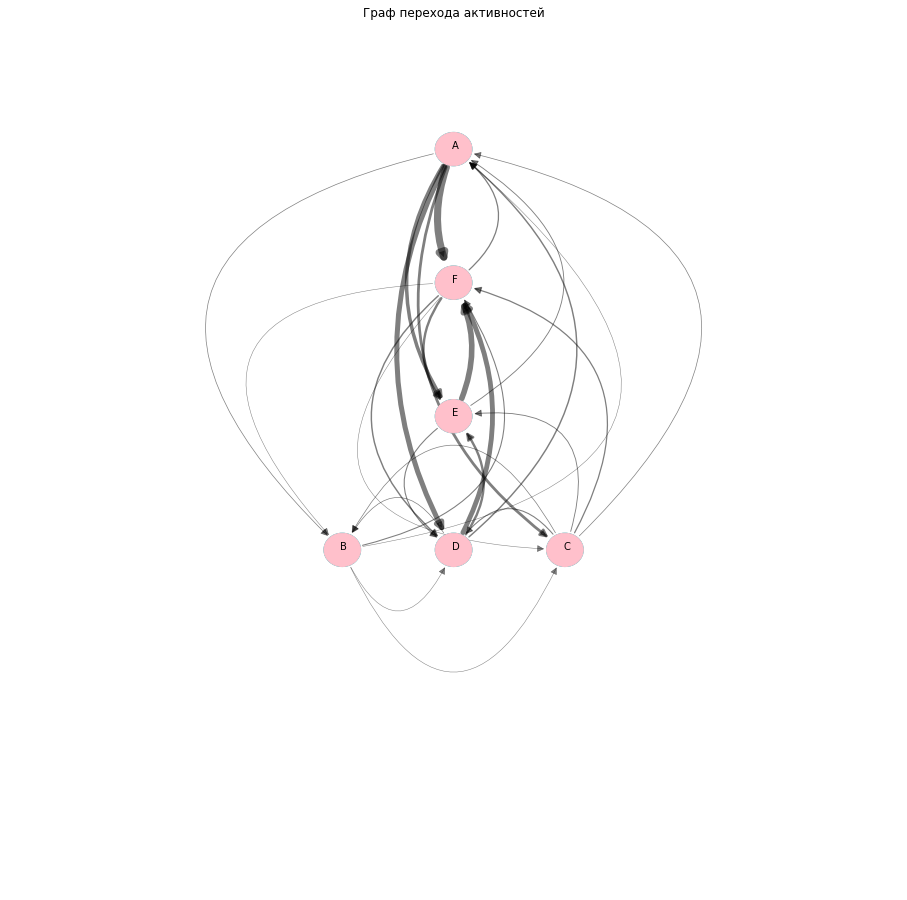

In [10]:
graph = Graph(gen_df, 'id', 'stage_id', 'user_id')
graph.create_activities_graph()
graph.draw_activities(alpha=0.6, labels=id_act)

### Using existing log

In [11]:
log = pd.read_csv("pm_data/Chapter_1/running-example.csv", sep=';')
log['datetime'] = pd.to_datetime(log["dd-MM-yyyy:HH.mm"], format='%d-%m-%Y:%H.%M')
log.drop("dd-MM-yyyy:HH.mm", axis=1, inplace=True)
log.head(10)

,Case ID,Event ID,Activity,Resource,Costs,datetime
0,1,35654423,register request,Pete,50,2010-12-30 11:02:00
1,1,35654424,examine thoroughly,Sue,400,2010-12-31 10:06:00
2,1,35654425,check ticket,Mike,100,2011-01-05 15:12:00
3,1,35654426,decide,Sara,200,2011-01-06 11:18:00
4,1,35654427,reject request,Pete,200,2011-01-07 14:24:00
5,2,35654483,register request,Mike,50,2010-12-30 11:32:00
6,2,35654485,check ticket,Mike,100,2010-12-30 12:12:00
7,2,35654487,examine casually,Sean,400,2010-12-30 14:16:00
8,2,35654488,decide,Sara,200,2011-01-05 11:22:00
9,2,35654489,pay compensation,Ellen,200,2011-01-08 12:05:00


In [12]:
log["User ID"] = log['Resource']
log['Activity ID'] = log['Activity']

act_id = dict()
id_act = dict()
usr_id = dict()
id_usr = dict()

for i, act in enumerate(np.unique(log.Activity)):
    act_id[act] = i
    id_act[i] = act

for i, usr in enumerate(np.unique(log.Resource)):
    usr_id[usr] = i
    id_usr[i] = usr

for i in range(log.shape[0]):
    log.loc[i,'User ID'] = usr_id[log.loc[i,'Resource']]
    log.loc[i,'Activity ID'] = act_id[log.loc[i,'Activity']]

In [13]:
log.head()

,Case ID,Event ID,Activity,Resource,Costs,datetime,User ID,Activity ID
0,1,35654423,register request,Pete,50,2010-12-30 11:02:00,2,5
1,1,35654424,examine thoroughly,Sue,400,2010-12-31 10:06:00,5,3
2,1,35654425,check ticket,Mike,100,2011-01-05 15:12:00,1,0
3,1,35654426,decide,Sara,200,2011-01-06 11:18:00,3,1
4,1,35654427,reject request,Pete,200,2011-01-07 14:24:00,2,7


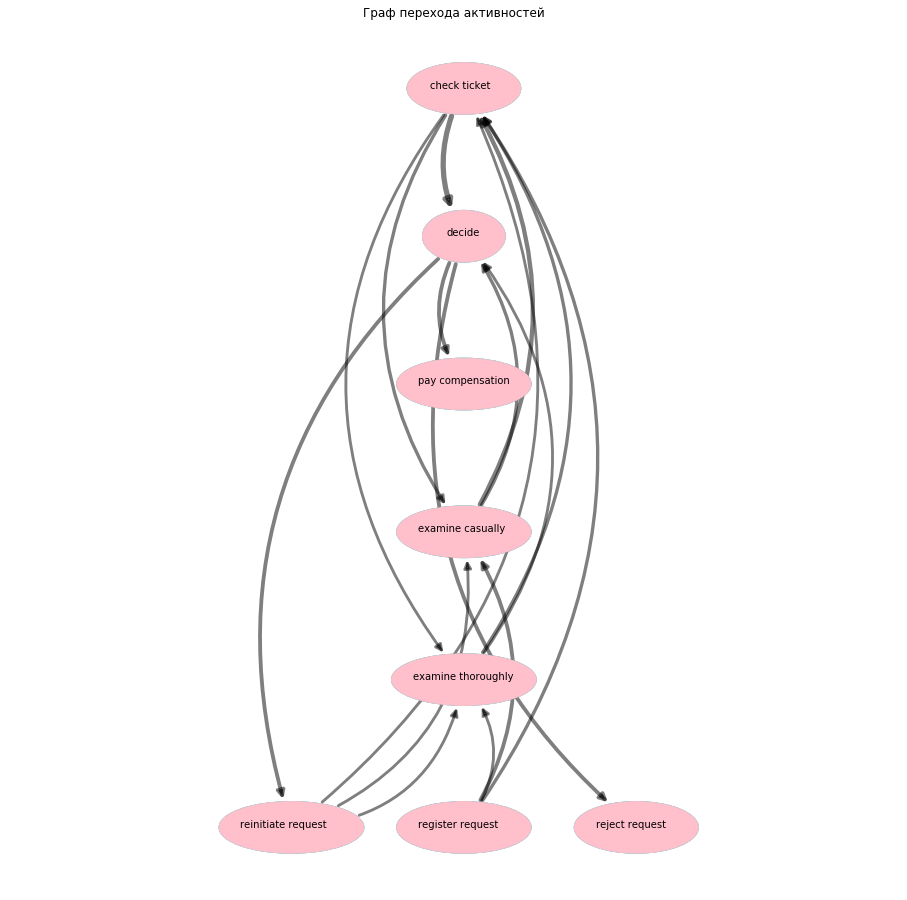

In [14]:
graph = Graph(log, 'Case ID', 'Activity ID', 'User ID')
graph.create_activities_graph()
graph.draw_activities(alpha=0.2, labels=id_act)

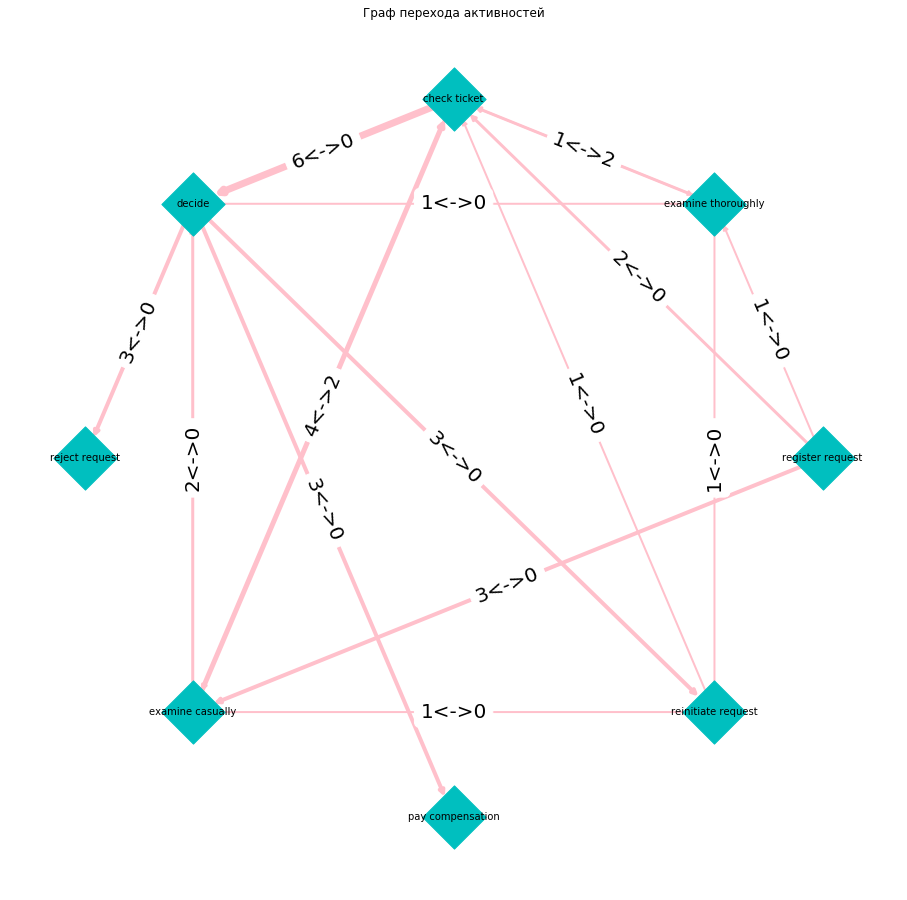

In [15]:
graph.draw_activities(alpha=1, labels=id_act, layout=nx.circular_layout, info='edges', node_size=2000, style=0)

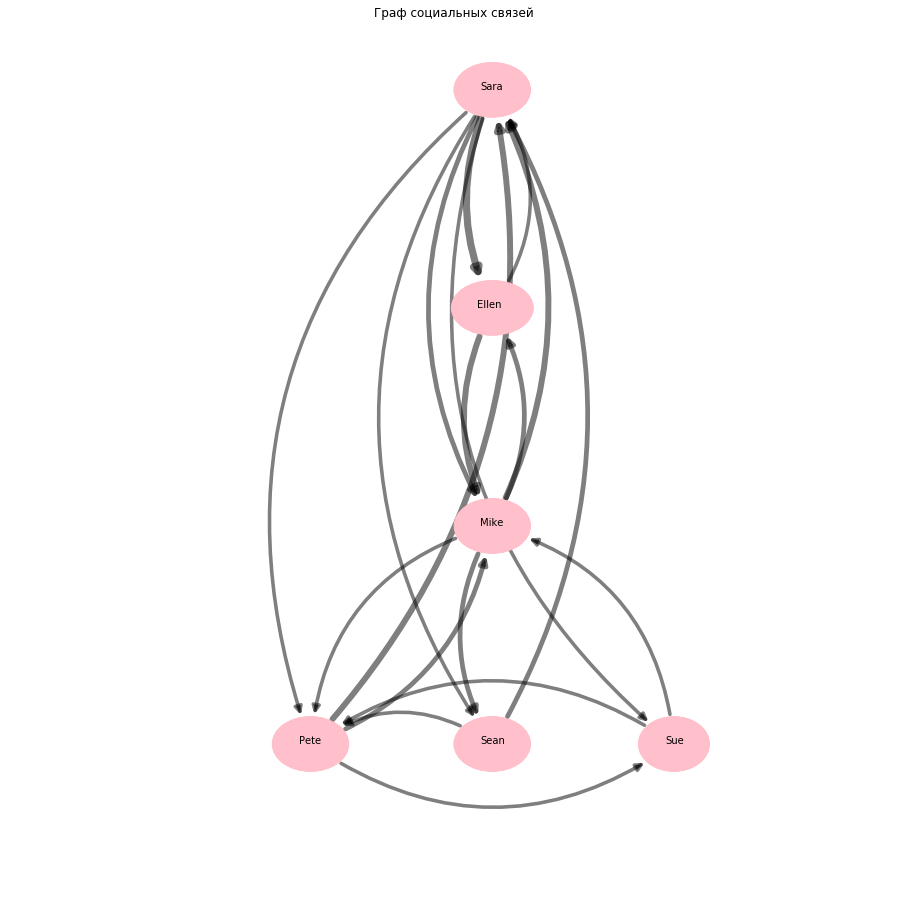

In [16]:
graph = Graph(log, 'Case ID', 'Activity ID', 'User ID')
g = graph.create_users_graph()
graph.draw_users(alpha=0.5, labels=id_usr,  info='edges')

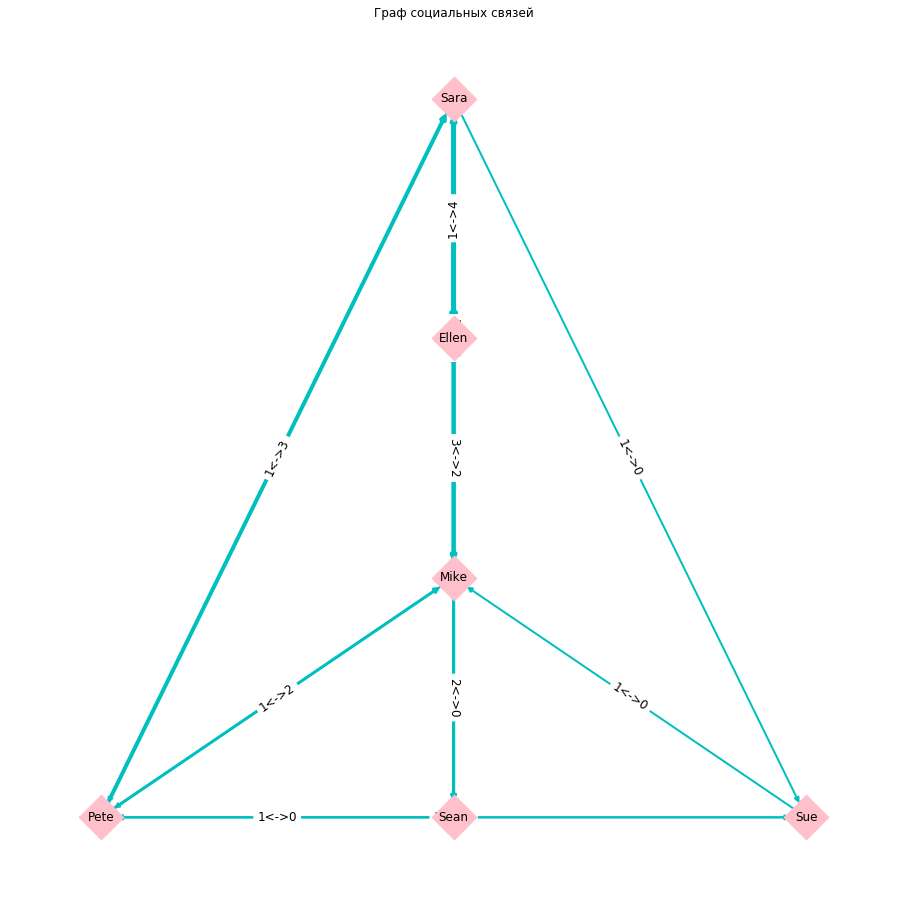

In [17]:
graph.draw_users(alpha=1, labels=id_usr, style=None, node_size=1000, info='edges')